In [1]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv
load_dotenv()

from script.database_pipeline import Pipeline

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Setting up DB

In [3]:
username = os.getenv('PSQL_USER')
password = os.getenv('PASS')
host = os.getenv('HOST')
port = os.getenv('PORT')

db_url = (f"postgresql+psycopg2://{username}:{password}@{host}:{port}/data_prof")

In [25]:
engine = create_engine(db_url)

In [15]:
# Converted into a csv
df = pd.read_csv('ds_2019.csv')

In [14]:
df.head()

,Survey Year,Timestamp,SalaryUSD,Country,PostalCode,PrimaryDatabase,YearsWithThisDatabase,OtherDatabases,EmploymentStatus,JobTitle,...,HoursWorkedPerWeek,TelecommuteDaysPerWeek,PopulationOfLargestCityWithin20Miles,EmploymentSector,LookingForAnotherJob,CareerPlansThisYear,Gender,OtherJobDuties,KindsOfTasksPerformed,Counter
0,2017,2017-01-05 05:10:20.451,200000,United States,Not Asked,Microsoft SQL Server,10,MySQL/MariaDB,Full time employee,DBA,...,45,1,Not Asked,Private business,"Yes, but only passively (just curious)",Not Asked,Not Asked,Not Asked,Not Asked,1
1,2017,2017-01-05 05:26:23.388,61515,United Kingdom,Not Asked,Microsoft SQL Server,15,"Oracle, PostgreSQL",Full time employee,DBA,...,35,2,Not Asked,Private business,No,Not Asked,Not Asked,Not Asked,Not Asked,1
2,2017,2017-01-05 05:32:57.367,95000,Germany,Not Asked,Microsoft SQL Server,5,"Oracle, MySQL/MariaDB, Informix",Full time employee,Other,...,45,"None, or less than 1 day per week",Not Asked,Private business,"Yes, but only passively (just curious)",Not Asked,Not Asked,Not Asked,Not Asked,1
3,2017,2017-01-05 05:33:03.316,56000,United Kingdom,Not Asked,Microsoft SQL Server,6,NaN,Full time employee,DBA,...,40,1,Not Asked,Private business,"Yes, but only passively (just curious)",Not Asked,Not Asked,Not Asked,Not Asked,1
4,2017,2017-01-05 05:34:33.866,35000,France,Not Asked,Microsoft SQL Server,10,Oracle,Full time employee of a consulting/contracting...,DBA,...,40,"None, or less than 1 day per week",Not Asked,Private business,"Yes, but only passively (just curious)",Not Asked,Not Asked,Not Asked,Not Asked,1


In [35]:
# pipe = Pipeline(engine)
# pipe.add_table(df, 'og')

### EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6893 entries, 0 to 6892
Data columns (total 29 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Survey Year                           6893 non-null   int64         
 1   Timestamp                             6893 non-null   datetime64[ns]
 2   SalaryUSD                             6893 non-null   object        
 3   Country                               6893 non-null   object        
 4   PostalCode                            5934 non-null   object        
 5   PrimaryDatabase                       6893 non-null   object        
 6   YearsWithThisDatabase                 6893 non-null   int64         
 7   OtherDatabases                        5520 non-null   object        
 8   EmploymentStatus                      6893 non-null   object        
 9   JobTitle                              6893 non-null   object        
 10  

In [6]:
df.isna().sum()

Survey Year                                0
Timestamp                                  0
SalaryUSD                                  0
Country                                    0
PostalCode                               959
PrimaryDatabase                            0
YearsWithThisDatabase                      0
OtherDatabases                          1373
EmploymentStatus                           0
JobTitle                                   0
ManageStaff                                0
YearsWithThisTypeOfJob                     0
HowManyCompanies                           0
OtherPeopleOnYourTeam                      0
CompanyEmployeesOverall                    0
DatabaseServers                            0
Education                                  0
EducationIsComputerRelated              1216
Certifications                             0
HoursWorkedPerWeek                         0
TelecommuteDaysPerWeek                     0
PopulationOfLargestCityWithin20Miles       0
Employment

In [17]:
countries = df['Country'].value_counts()
countries.head()

United States     4509
United Kingdom     667
Canada             244
Australia          185
India              112
Name: Country, dtype: int64

### Looking at US to start with

since majority of the data is in US

In [372]:
from script.helper import plot_quant, plot_cat

In [16]:
us = df[df['Country'] == 'United States']

In [105]:
us.isna().sum()

Survey Year                               0
Timestamp                                 0
SalaryUSD                                 0
Country                                   0
PostalCode                              302
PrimaryDatabase                           0
YearsWithThisDatabase                     0
OtherDatabases                          873
EmploymentStatus                          0
JobTitle                                  0
ManageStaff                               0
YearsWithThisTypeOfJob                    0
HowManyCompanies                          0
OtherPeopleOnYourTeam                     0
CompanyEmployeesOverall                   0
DatabaseServers                           0
Education                                 0
EducationIsComputerRelated              709
Certifications                            0
HoursWorkedPerWeek                        0
TelecommuteDaysPerWeek                    0
PopulationOfLargestCityWithin20Miles      0
EmploymentSector                

In [346]:
features = ['SalaryUSD', 'YearsWithThisDatabase', 'ManageStaff', 'YearsWithThisTypeOfJob', 'OtherPeopleOnYourTeam', 'Education', 'HoursWorkedPerWeek', 'TelecommuteDaysPerWeek', 'EmploymentSector', 'CareerPlansThisYear', 'Gender', 'OtherJobDuties', 'KindsOfTasksPerformed']
target = ['LookingForAnotherJob', ]

### Salary

In [18]:
us.loc[:, 'SalaryUSD'] = us['SalaryUSD'].apply(str).str.replace(',|\s+', '', regex=True).astype(float)

/usr/local/anaconda3/envs/cap1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [22]:
us['SalaryUSD'].describe()

count    4.509000e+03
mean     1.075171e+05
std      5.717729e+04
min      9.227000e+01
25%      8.500000e+04
50%      1.020000e+05
75%      1.220000e+05
max      1.450000e+06
Name: SalaryUSD, dtype: float64

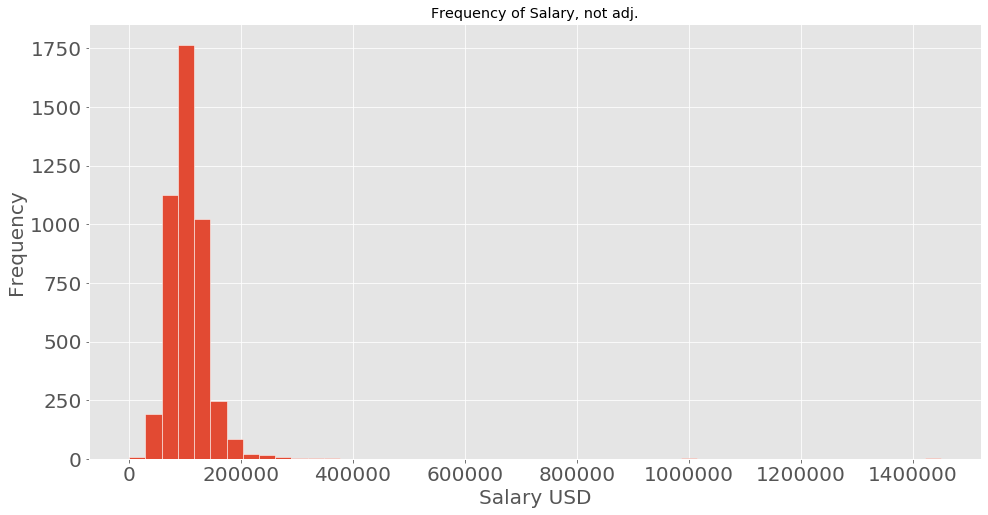

In [373]:
fig, ax = plt.subplots(figsize=(16, 8))
(plot_quant(ax, us['SalaryUSD'], xlabel='Salary USD', ylabel='Frequency',
                 title='Frequency of Salary, not adj.', bins=50, edgecolor='white'))

### Remove salary outliers

In [108]:
salary = us['SalaryUSD']

In [347]:
salary.describe()

count    4.509000e+03
mean     1.075171e+05
std      5.717729e+04
min      9.227000e+01
25%      8.500000e+04
50%      1.020000e+05
75%      1.220000e+05
max      1.450000e+06
Name: SalaryUSD, dtype: float64

In [112]:
salary_q3 = salary.describe()['75%']
salary_q1 = salary.describe()['25%']

salary_iqr = salary_q3 - salary_q1
salary_adj = salary[(salary < (salary_q3 + 1.5 * salary_iqr)) & (salary > (salary_q1 - 1.5 * salary_iqr))]

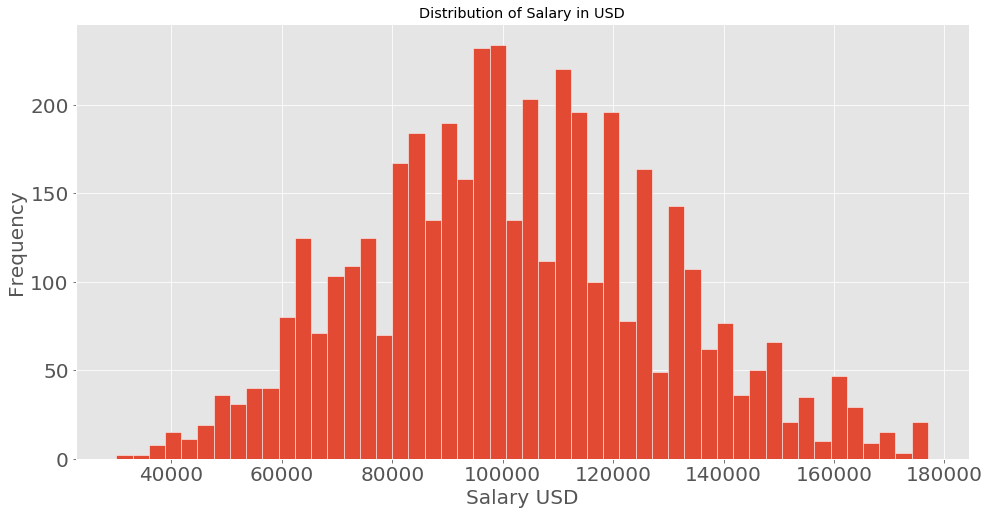

In [374]:
fig, ax = plt.subplots(figsize=(16, 8))
(plot_quant(ax, salary_adj, xlabel='Salary USD', ylabel='Frequency',
                 title='Distribution of Salary in USD', bins=50, edgecolor='white'))

### Years with this database

In [147]:
us['YearsWithThisDatabase'].value_counts()

10       486
15       432
20       369
5        304
4        241
17       232
3        231
8        226
7        222
18       221
12       219
6        216
2        163
16       155
13       111
1        109
11       100
9         99
14        88
25        61
19        58
21        43
22        42
23        29
24        13
30         9
0          6
28         6
26         5
27         4
32         2
2011       1
2000       1
2004       1
30331      1
38         1
53716      1
29         1
Name: YearsWithThisDatabase, dtype: int64

In [148]:
year_db = us['YearsWithThisDatabase']

In [149]:
yeardb_q3 = year_db.describe()['75%']
yeardb_q1 = year_db.describe()['25%']

yeardb_iqr = yeardb_q3 - yeardb_q1
yeardb_adj = year_db[(year_db < (yeardb_q3 + 1.5 * yeardb_iqr)) & (year_db > (yeardb_q1 - 1.5 * yeardb_iqr))]

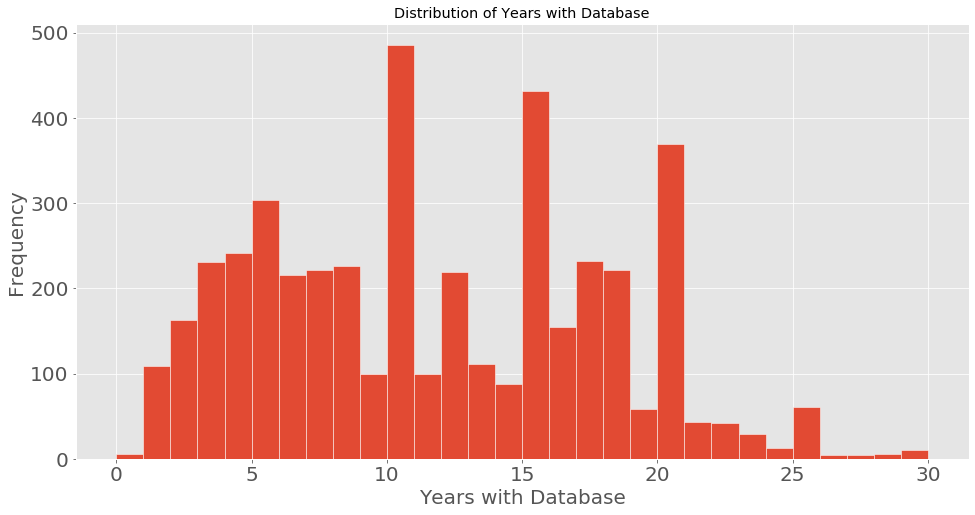

In [375]:
fig, ax = plt.subplots(figsize=(16, 8))
(plot_quant(ax, yeardb_adj, xlabel='Years with Database', ylabel='Frequency',
                 title='Distribution of Years with Database', bins=30, edgecolor='white'))

### Manage Staff

In [205]:
us['ManageStaff'].value_counts()

No     3498
Yes    1011
Name: ManageStaff, dtype: int64

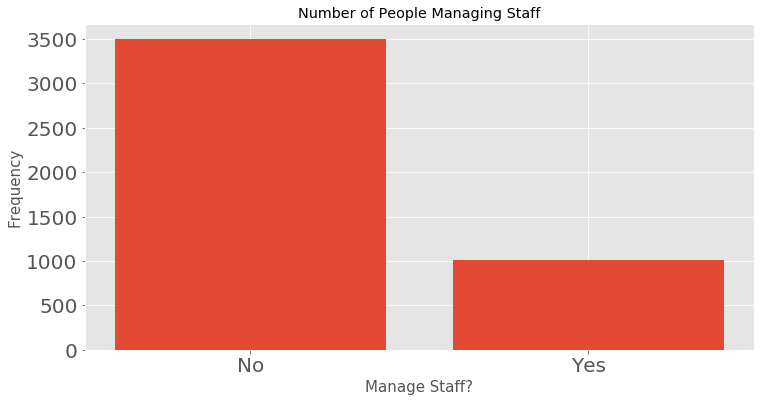

In [383]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_cat(ax, us['ManageStaff'].value_counts(), xlabel='Manage Staff?', ylabel='Frequency', 
              title='Number of People Managing Staff'))

### Years With This Type of Job

In [224]:
us['YearsWithThisTypeOfJob'].value_counts()

1     531
2     520
3     499
5     448
4     397
10    326
6     257
7     212
15    186
8     184
20    150
12    119
9      80
18     72
17     69
11     59
16     52
13     51
25     49
0      38
14     37
22     30
19     26
21     20
30     18
23     14
28     10
24      9
29      8
26      7
27      6
32      6
35      4
38      3
34      2
33      2
31      2
40      2
36      2
39      1
37      1
Name: YearsWithThisTypeOfJob, dtype: int64

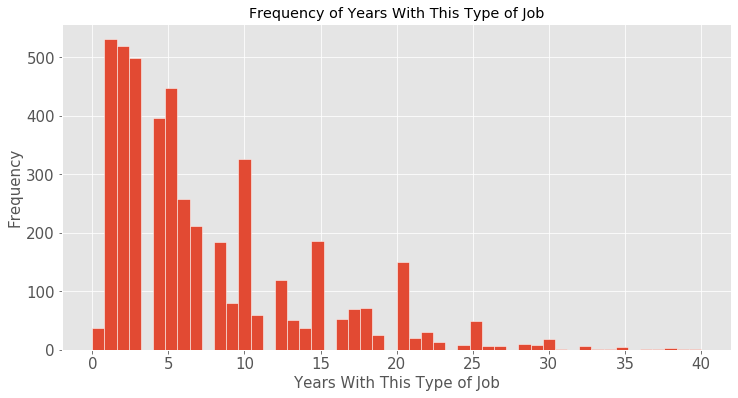

In [385]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_quant(ax, us['YearsWithThisTypeOfJob'], xlabel='Years With This Type of Job', ylabel='Frequency',
                        title='Frequency of Years With This Type of Job', bins=50, edgecolor='white'))

### Amount of Others on Your Team

Label Encode ordinality

In [245]:
us['OtherPeopleOnYourTeam'].value_counts()

None           1842
1               942
2               521
More than 5     422
3               378
4               239
5               165
Name: OtherPeopleOnYourTeam, dtype: int64

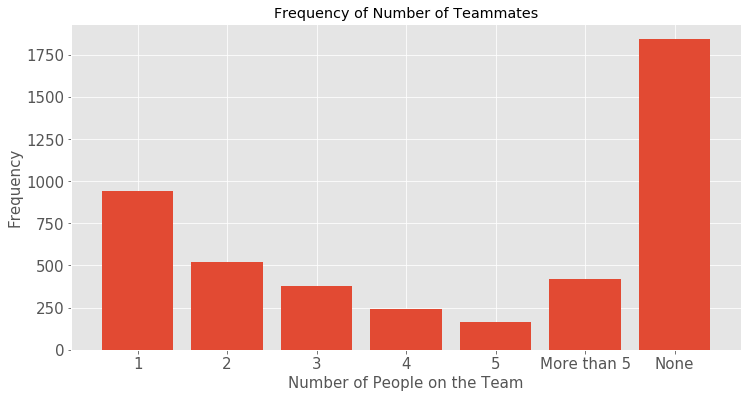

In [387]:
fig, ax = plt.subplots(figsize=(12, 6))

(plot_cat(ax, us['OtherPeopleOnYourTeam'].value_counts().sort_index(), xlabel='Number of People on the Team', ylabel='Frequency',
                                         title='Frequency of Number of Teammates'))

### Education Level

Label Encode ordinality

In [252]:
us['Education'].value_counts()

Bachelors (4 years)           2548
Masters                        762
None (no degree completed)     672
Associates (2 years)           503
Doctorate/PhD                   24
Name: Education, dtype: int64

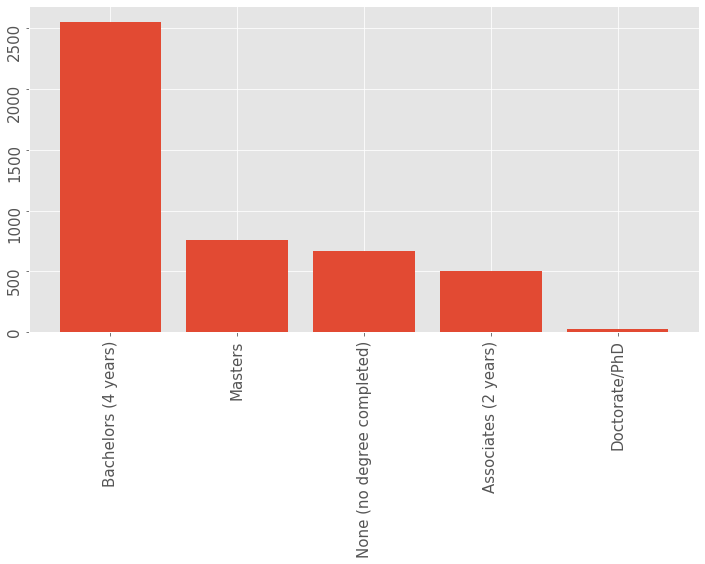

In [395]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_cat(ax, us['Education'].value_counts()))
ax.tick_params(rotation=90)

### Hours Work Per Week

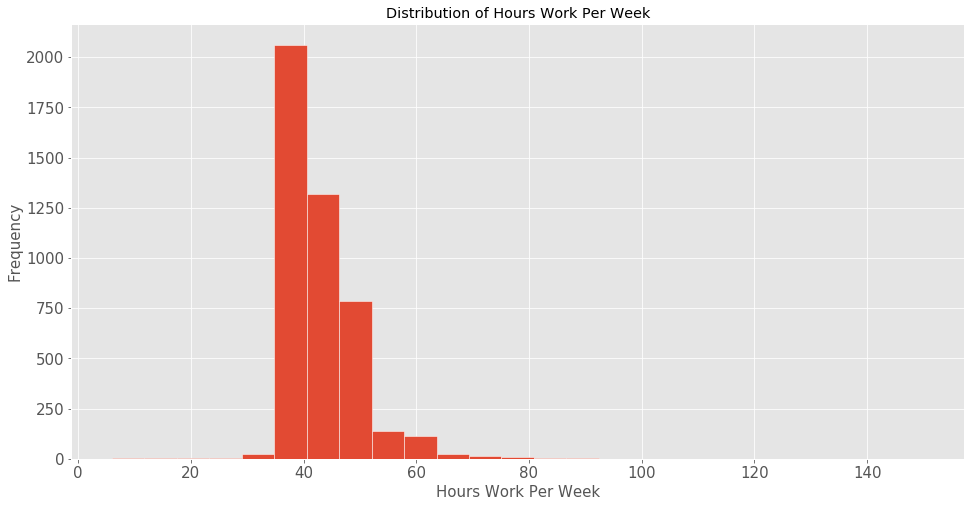

In [396]:
fig, ax = plt.subplots(figsize=(16, 8))
(plot_quant(ax, us['HoursWorkedPerWeek'], xlabel='Hours Work Per Week', ylabel='Frequency',
                 title='Distribution of Hours Work Per Week', bins=25, edgecolor='white'))

### Telecommute Days Per Week

Label Encode ordinality

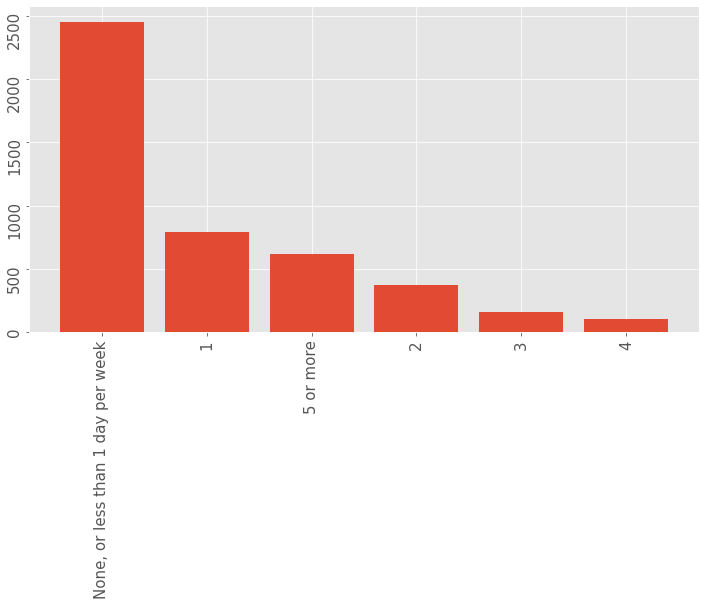

In [397]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_cat(ax, us['TelecommuteDaysPerWeek'].value_counts()))
ax.tick_params(rotation=90)

### Employment Sector

Label Encode

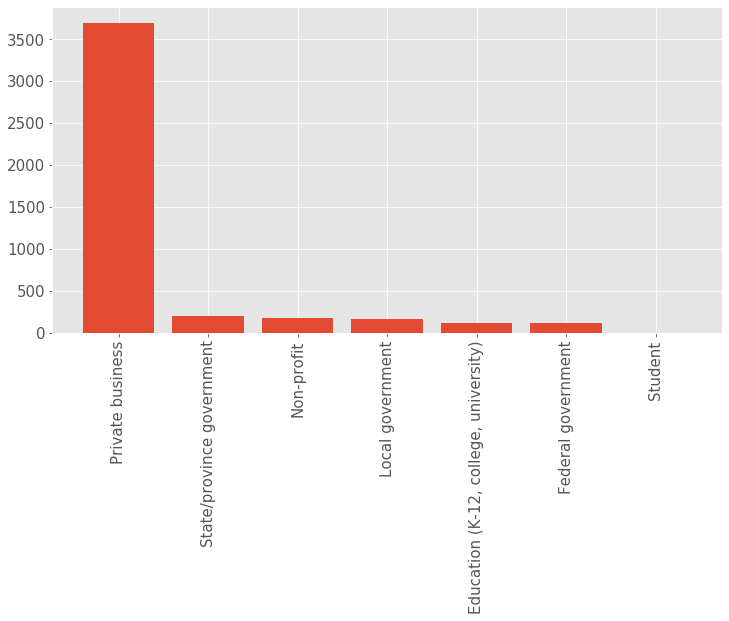

In [406]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_cat(ax, us['EmploymentSector'].value_counts()))

_ = ax.set_xticklabels(labels=us['EmploymentSector'].value_counts().index, rotation=90)

### Career Plans This Year

One hot encode

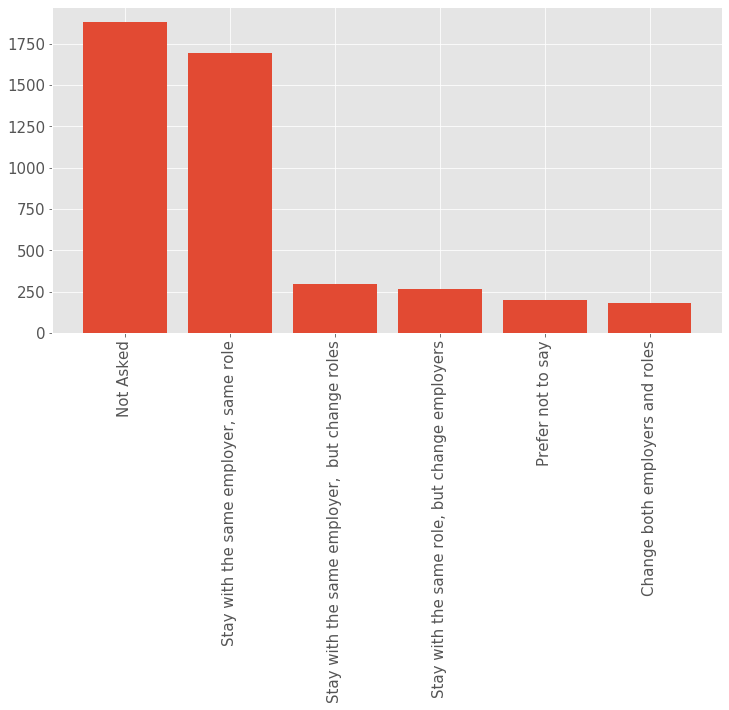

In [410]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_cat(ax, us['CareerPlansThisYear'].value_counts()))

_ = ax.set_xticklabels(labels=us['CareerPlansThisYear'].value_counts().index, rotation=90)

### Gender

Might have to drop gender due to high number of NaNs/Not Asked.

In [365]:
def clean_gender(row):
    if (row not in ['Male', 'Female']):
        return 'Not Asked'
    return row

In [367]:
us['Gender'].apply(clean_gender).value_counts()

Male         2266
Not Asked    1922
Female        321
Name: Gender, dtype: int64

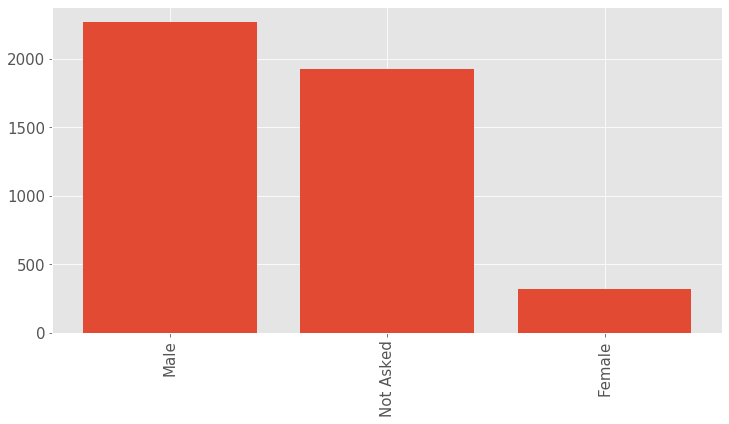

In [412]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_cat(ax, us['Gender'].apply(clean_gender).value_counts()))

_ = ax.set_xticklabels(labels=us['Gender'].apply(clean_gender).value_counts().index, rotation=90)

### Amount of Other Job Duties

Might have to exclude, due to high number of nans/No answers

In [360]:
us['OtherJobDuties'].replace('Not Asked', np.nan).isna().sum() / us['OtherJobDuties'].size

0.5021068973164782

In [325]:
ojd = us['OtherJobDuties'].dropna().str.replace('Not Asked', 'N/A').str.replace('\\(.*\\)', '', regex=True).apply(lambda x: x.split(','))

In [326]:
def filter_NA(row):
    if ('N/A' in row):
        return None
    return row

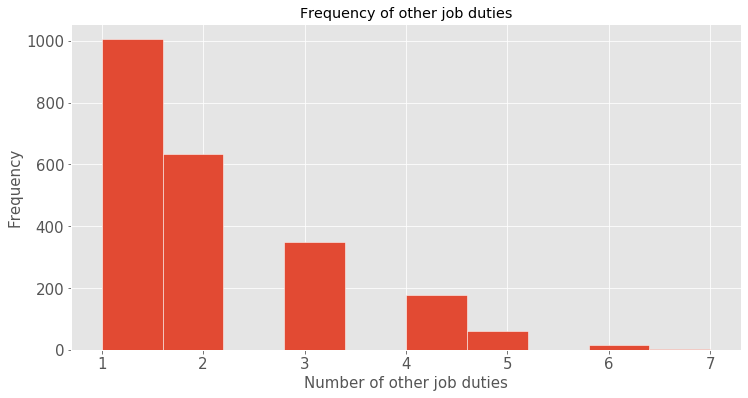

In [417]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_quant(ax, ojd.apply(filter_NA).dropna().apply(lambda x: len(x)), xlabel='Number of other job duties', ylabel='Frequency', 
                        title='Frequency of other job duties',edgecolor='white'))


### Future plans

In [169]:
# countries_more_than_ten = countries.index[countries > 10]
# df = df[df['Country'].isin(countries_more_than_ten)]
# df.head()